# Upselling Customers

The company that has hired us wants to upsell existing customers to make more money, which means they want to try and get existing customers to buy more stuff.

As we read about in the corresponding blog post linked to above, we can use the expected value framework to break this problem down. 

A piece of the problem is being able to predict the probability that we will successfully upsell any given customer that we reach out to. Luckily, the company has historical customer data on customers who they tried to upsell before, and whether each one was successfully upsold or not. We can build a machine learning model from this data to give us the probabilities we're looking for.

### Build a model #

In [1]:
# modules and config needed
from pandas import *
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Load the customer data

In [2]:
X = DataFrame.from_csv('data/orange_small_train.data', sep='\t', index_col=None)

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [3]:
X.shape

(50000, 230)

Unfortunately variable names have been masked, but we can imagine the data containing descriptive information, like the customer's location or age, and/or behavioral information, like how many purchases the customer has made before, how many times they've come back to the company's website, etc.

In [4]:
X.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230
count,702.000000,1241.000000,1240.000000,1579.000000,1.487000e+03,44471.000000,44461.000000,0.0,702.000000,1.487000e+03,...,1.241000e+03,1241.000000,0.0,702.000000,702.00000,1241.000000,21022.000000,333.000000,0.0,0.0
mean,11.487179,0.004029,425.298387,0.125396,2.387933e+05,1326.437116,6.809496,NaN,48.145299,3.926057e+05,...,7.777380e+04,8.460919,NaN,3.299145,16.54416,167.368477,270.142137,22007.045192,NaN,NaN
std,40.709951,0.141933,4270.193518,1.275481,6.441259e+05,2685.693668,6.326053,NaN,154.777855,9.280896e+05,...,2.016188e+05,46.973777,NaN,8.781967,60.22303,113.980072,86.707692,29085.146490,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,0.00000,-6.420000,6.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,518.000000,0.000000,NaN,4.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,0.00000,19.380000,204.000000,2732.670000,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,861.000000,7.000000,NaN,20.000000,0.000000e+00,...,0.000000e+00,0.000000,NaN,0.000000,4.00000,197.640000,270.000000,12668.940000,NaN,NaN
75%,16.000000,0.000000,0.000000,0.000000,1.187425e+05,1428.000000,7.000000,NaN,46.000000,2.628630e+05,...,4.881000e+04,8.000000,NaN,6.000000,14.00000,252.960000,330.000000,29396.340000,NaN,NaN
max,680.000000,5.000000,130668.000000,27.000000,6.048550e+06,131761.000000,140.000000,NaN,2300.000000,1.232559e+07,...,3.048400e+06,1200.000000,NaN,102.000000,910.00000,628.620000,642.000000,230427.000000,NaN,NaN


Load "new" customers, or customers our model won't be trained on / hasn't seen yet

In [6]:
X_new = DataFrame.from_csv('data/orange_small_test.data', sep='\t', index_col=None)
X_new.shape

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


(50000, 230)

Load target data.

The target data specifies for each customer, whether he/she was successfully upsold or not.

In [7]:
y = Series.from_csv('data/orange_small_train_upselling.labels.txt', header=None, index_col=None)

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [8]:
y.shape

(50000,)

Target classes are pretty unbalanced. Only about 7% of customers were successfully upsold, or convinced to buy more products from us after we reached out to them.

In [9]:
y.groupby(y).agg({0: 'count'}) / len(y)

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,0
-1,0.92636
1,0.07364


Concatenate historical customer data with new customer data so that we can do data pre-processing on one single DataFrame

In [10]:
X_all = pd.concat([X, X_new])
X_all.shape

(100000, 230)

**Pre-processing**

Drop completely empty columns. 

Drop non-numeric columns too for simplicity, because the data that goes into a machine learning model has to be numeric. In reality, non-numeric columns could contain valuable information for predicting the target variable, so part of the feature engineering phase could be converting those strings to numbers, such as word frequencies for example.

In [11]:
X_all = X_all.dropna(axis=1, how='all') # drop completely empty columns
X_all.shape

(100000, 212)

In [12]:
X_all = X_all._get_numeric_data() # keep only numeric columns
X_all.shape

(100000, 174)

Split customer data back into historical customer data, and new customer data

In [15]:
X = X_all[:len(X)]
X_new = X_all[len(X):]
print(X.shape)
print(X_new.shape)

(50000, 174)
(50000, 174)


**Create holdout set**

So we can train the model on one set and test the model's performance on another set to reduce overfitting risk.

In [16]:
random_state = 42

Use train_test_split to split data into training and test sets. Specify "stratify" parameter to make sure it doesn't accidentally create a y_train or y_test set that is all one target class, which could happen because our target classes are pretty imbalanced.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state, stratify=y)

**Feature engineering**

Next, you would engage in feature engineering, which is transforming the data to help any model we build from it make better predictions.

Fit an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html), on X_train, which fills missing values with the column-wise mean (in X_train).

Why impute? Because a lot of our customer data seems to be missing attributes, or values for certain features, and most machine learning models can't handle training themselves on a set of data that has missing values here and there. So instead of throwing away customer data that have missing values and reducing the amount of data the model has to use, a common solution is to fill in the missing values with the column/feature's mean value.

In [18]:
imputer = Imputer(missing_values="NaN",
                    strategy="mean",
                    axis=0)

In [19]:
imputer = imputer.fit(X_train)

In [20]:
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

You can, and should, conduct more feature engineering than just imputing missing values, to help make the model as predictive as possible. We will leave this as an exercise for the reader.

Note that using an sklearn [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is an easy way to establish a series of data transforms followed by a model/estimator that can be applied in the same way to different sets of data.

No model tuning here, for simplicity. Model tuning is determining the "best" paramters for a tweaking machine learning model itself, with the hopes of improving performance. 

**Fit a model and evaluate its performance**

We're trying to answer: "given historical data on a subset of customers and whether or not we were able to upsell them, how good are we at predicting whether we'll be able to upsell our other customers?"

Fit a decision tree model, on the transformed training data.

In [21]:
dt = DecisionTreeClassifier(max_depth=5) # specify a max depth for the tree, because otherwise it can get very complex and overfit more
dt = dt.fit(X_train_imputed, y_train.as_matrix()) # use "as_matrix()" to pass in data as a matrix of values, because pandas DataFrames sometimes screw with scikit functions. 

How does our decision tree perform? Compare its predictions on the transformed *test* data, with the actual/real target values.

In [23]:
y_hat = dt.predict(X_test_imputed)
print('Accuracy: ', accuracy_score(y_test.as_matrix(), y_hat))
print('F1 score: ', f1_score(y_test.as_matrix(), y_hat))
print('ROC AUC score: ', roc_auc_score(y_test.as_matrix(), y_hat))

Accuracy:  0.94792
F1 score:  0.5437981779957954
ROC AUC score:  0.7057313959600511


^ Some standard measures of performance. How each one works, and pros/cons of using each one for evaluation are discussed elsewhere (perhaps in a future exercise), but here, according to ROC AUC, it looks like our decision tree performs a bit better than random guessing (which has an ROC AUC of 0.5). 

### Using our model and expected value to decide which customers to try and upsell ###

Assume we've decided that our model is good enough.* How do we use it to decide whether we should upsell a customer or not?

*<sub>In reality, it's not (a perfect F1 Score is 1, and we're not close), and we'd have to go back and engineer some more features, tune the model, and/or try different machine learning models altogether to get the best performance we can, and thus most confidence that our model is able to predict accurate class probabilities.</sup>

Remember from the blog post that using the expected value framework, our expected *profit* for trying to upsell any given customer is:

$$E(Profit) = p_u * (v_u - c) + (1 - p_u) * (-c) $$

Where $p_u$ is the probability of successfully upselling the customer, $v_u$ is the revenue that each successful upsell would generate (assumed constant at \$100), and $c$ is the cost of upselling (assumed constant at \$15).

And so, to maximize profits, we should only upsell those customers who have an $E(Profit) > 0$ 

First, rebuild our model on *all* our data. We do this *after* we've evaluated its performance out of sample (i.e. training it on a train set, and evaluating its performance on a test set) to reduce the risk of overfitting.

In [24]:
imputer = imputer.fit(X) # refit imputer
X_imputed = imputer.transform(X) # impute any missing values in our feature matrix
dt = dt.fit(X_imputed, y.as_matrix()) # refit our decision tree classifier

Predict each "new" customer's probability of being upsold successfully. Remember our set of "new" customers are the 50,000 customers our model hasn't seen yet.

In [25]:
X_new_imputed = imputer.transform(X_new) # fill in any missing values in the feature matrix for the customers we haven't seen yet, using the column-wise mean calculated from the customers we already trained the model on
p_u = [x[1] for x in dt.predict_proba(X_new_imputed)]

Calculate the expected profit of upselling any one of our "new" customers, or customers our model hasn't seen yet:

In [27]:
p_u

[0.08808340641138068,
 0.01038233355306526,
 0.08808340641138068,
 0.08808340641138068,
 0.08808340641138068,
 0.0011950027159152634,
 0.06322075782537068,
 0.02655093183558846,
 0.8791878172588833,
 0.0011950027159152634,
 0.8791878172588833,
 0.0011950027159152634,
 0.1415929203539823,
 0.06322075782537068,
 0.08808340641138068,
 0.06409949772781631,
 0.0003183699458771092,
 0.02655093183558846,
 0.08808340641138068,
 0.01038233355306526,
 0.08808340641138068,
 0.042994042994043,
 0.0011950027159152634,
 0.01038233355306526,
 0.02655093183558846,
 0.0011950027159152634,
 0.0011950027159152634,
 0.042994042994043,
 0.01038233355306526,
 0.08808340641138068,
 0.08808340641138068,
 0.0011950027159152634,
 0.0003183699458771092,
 0.0011950027159152634,
 0.06409949772781631,
 0.08808340641138068,
 0.06409949772781631,
 0.0011950027159152634,
 0.042994042994043,
 0.08808340641138068,
 0.042994042994043,
 0.042994042994043,
 0.0011950027159152634,
 0.042994042994043,
 0.08808340641138068,
 

In [28]:
## Fully inclusive profit
expected_profit_of_upsell = np.multiply(p_u, (100-15)) + np.multiply(np.subtract(1, p_u), -15) # using numpy functions for multiplying a vector element-wise by a scalar

In [29]:
expected_profit_of_upsell = Series(expected_profit_of_upsell, index=X_new.index) # turn into a pandas Series with customer numbers
expected_profit_of_upsell.head()

0    -6.191659
1   -13.961767
2    -6.191659
3    -6.191659
4    -6.191659
dtype: float64

Let's visualize our total expected profit of trying to upsell the top x% (ranked by probability of success) of our "new" customers:

In [30]:
expected_profit_of_upsell.sort_values(inplace=True, ascending=False) # sort expected profit descending
cumulative_profit_of_upsell = expected_profit_of_upsell.cumsum() # calculate cumulative total profit
cumulative_profit_of_upsell_df = DataFrame({
        'Expected Total Profit': cumulative_profit_of_upsell, 
        'Upsell Top x%': Series(
            [float(i+1) / len(cumulative_profit_of_upsell) * 100 for i in range(len(cumulative_profit_of_upsell))], 
            index=cumulative_profit_of_upsell.index)
    }) # calculate "top x%", for plotting

In [31]:
max_profit = cumulative_profit_of_upsell_df.ix[cumulative_profit_of_upsell_df['Expected Total Profit'].argmax()]
max_profit

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  if __name__ == '__main__':


Expected Total Profit    141184.987222
Upsell Top x%                 4.860000
Name: 15231, dtype: float64

In [33]:
print((max_profit['Upsell Top x%']/100. * len(cumulative_profit_of_upsell_df)))
print(len(cumulative_profit_of_upsell_df))

2430.0
50000


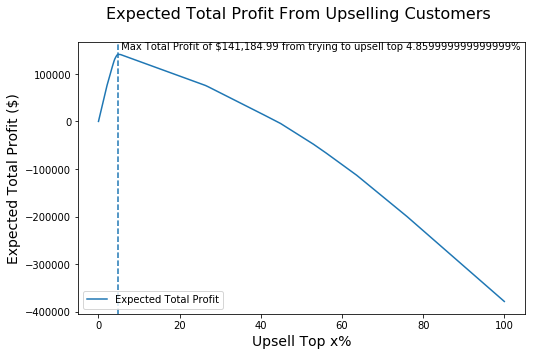

In [34]:
axes = cumulative_profit_of_upsell_df.plot(x='Upsell Top x%', y='Expected Total Profit', figsize=(8,5))

axes.text(max_profit['Upsell Top x%'], max_profit['Expected Total Profit']+10000, 
          " Max Total Profit of %s from trying to upsell top %s%%" % 
          ('${:,.2f}'.format(max_profit['Expected Total Profit']), max_profit['Upsell Top x%'])
         )
plt.axvline(x=max_profit['Upsell Top x%'], linestyle='--')
plt.legend(loc=3)
plt.title("Expected Total Profit From Upselling Customers \n", fontsize=16)
plt.xlabel("Upsell Top x%", fontsize=14)
plt.ylabel("Expected Total Profit ($)", fontsize=14)

Maximum expected total profit is achieved if we try to upsell the top 4.86% of our set of customers the model hasn't seen yet (50,000 of them), or the top 2,430, when ranked by expected profit of upselling each individual customer in descending order.